In [7]:
pwd

'C:\\Users\\Admin'

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [9]:
xl_file = pd.ExcelFile('E:/Online Retail.xlsx')

In [10]:
Online_Retail = xl_file.parse('Online Retail')
Online_Retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [11]:
Online_Retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [12]:
Online_Retail.shape

(541909, 8)

 # Clean data

In [13]:
round(100*(Online_Retail.isnull().sum())/len(Online_Retail), 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [14]:
# drop rows with missing values
Online_Retail = Online_Retail.dropna()
Online_Retail.shape

(406829, 8)

In [15]:
Online_Retail['amount'] = Online_Retail['Quantity']*Online_Retail['UnitPrice']
Online_Retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


# Preparation of data for modelling

- R (Recency) : Number of days since last purchase
- F (Frequency) : Number of transactions
- M (Monetary) : Total amount of transactions

In [16]:
# monetary
grouped_df = Online_Retail.groupby('CustomerID')['amount'].sum()
grouped_df = grouped_df.reset_index()
grouped_df.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [17]:
# frequency
frequency = Online_Retail.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'frequency']
frequency.head()

,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [18]:
# merge two dataframes
grouped_df = pd.merge(grouped_df, frequency, on='CustomerID', how='inner')
grouped_df.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [19]:
# recency
# convert to datetime
Online_Retail['InvoiceDate'] = pd.to_datetime(Online_Retail['InvoiceDate'],
                                             format='%d-%m-%Y %H:%M')

In [20]:
Online_Retail.head()
Online_Retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   amount       406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


In [21]:
# compute the max date
max_date = max(Online_Retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [22]:
# compute the diff
Online_Retail['diff'] = max_date - Online_Retail['InvoiceDate']
Online_Retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [23]:
last_purchase = Online_Retail.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00
...,...,...
4367,18280.0,277 days 02:58:00
4368,18281.0,180 days 01:57:00
4369,18282.0,7 days 01:07:00
4370,18283.0,3 days 00:48:00


In [24]:
grouped_df = pd.merge(grouped_df, last_purchase, on='CustomerID', how='inner')
grouped_df.columns = ['CustomerID', 'amount', 'frequency', 'recency']
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [25]:
# number of days in recency
grouped_df['recency'] = grouped_df['recency'].dt.days
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


{'whiskers': [<matplotlib.lines.Line2D at 0x1c2c5dea388>,
 'caps': [<matplotlib.lines.Line2D at 0x1c2c0e886c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c2b7e93b88>],
 'medians': [<matplotlib.lines.Line2D at 0x1c2a87c2dc8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c2a87bcb88>],
 'means': []}

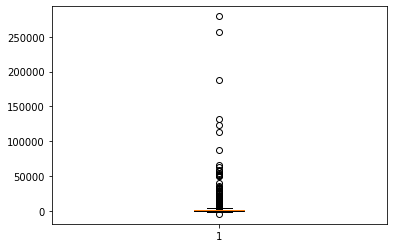

In [26]:
# 1.outlier treatment 
# plt will create vertical facing boxplot & sns horizontal
plt.boxplot(grouped_df['amount'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1c2a86aa9c8>,
 'caps': [<matplotlib.lines.Line2D at 0x1c2a8784908>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c2a8d7f688>],
 'medians': [<matplotlib.lines.Line2D at 0x1c2a86b0788>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c2a86b9948>],
 'means': []}

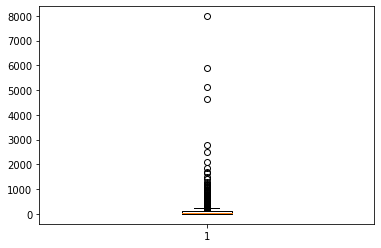

In [27]:
plt.boxplot(grouped_df['frequency'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1c2b3080048>,
 'caps': [<matplotlib.lines.Line2D at 0x1c2b3098148>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c2a9c389c8>],
 'medians': [<matplotlib.lines.Line2D at 0x1c2b307a308>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c2b307a048>],
 'means': []}

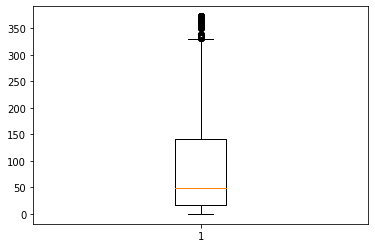

In [28]:
plt.boxplot(grouped_df['recency'])

In [29]:
# removing statistical outliers
Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount <= Q3 + 1.5*IQR)]

# for recency
Q1 = grouped_df.recency.quantile(0.05)
Q3 = grouped_df.recency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3 + 1.5*IQR)]

# for frequency
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.frequency >= Q1 - 1.5*IQR) & (grouped_df.frequency <= Q3 + 1.5*IQR)]

In [30]:
# rescalling
rfm_df = grouped_df[['amount', 'frequency', 'recency']]
rfm_df.head()

# instantiate scaler
scaler = StandardScaler()

# fit _transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled
# rfm_df_scaled.shape      can also be runned

array([[-0.72373821, -0.75288754,  2.30161144],
       [ 1.73161722,  1.04246665, -0.90646561],
       [ 0.30012791, -0.46363604, -0.18365813],
       ...,
       [-0.67769602, -0.70301659,  0.86589794],
       [-0.6231313 , -0.64317145, -0.84705678],
       [ 0.32293822, -0.07464263, -0.50050524]])

In [31]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


# Modelling

In [32]:
# k-means with arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [33]:
kmeans.labels_
# len(kmeans.labels_)   to see len

array([1, 0, 2, ..., 1, 2, 2])

# Finding the Optimal Number of Clusters

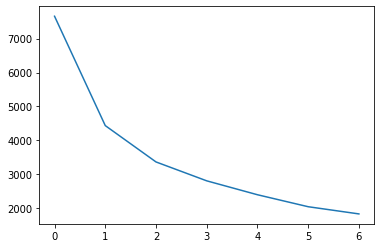

In [34]:
# elbow-curve/ssd
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    
    ssd.append(kmeans.inertia_)

# plot the sum of squared distances(ssd) for each n_clusters    
plt.plot(ssd)    

# Silhouette Analysis
                                       sillhouette score =   p - q
                                                           -----------
                                                            max(p,q)

In [35]:
# data point num 10 (cluster-1)
#p = 100
#q = 10
#90/100 = 0.9

#for 15
#p = 10
#q = 12
#-2/12= -1/6

In [36]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.48148099614734263
For n_clusters=5, the silhouette score is 0.4662700564189704
For n_clusters=6, the silhouette score is 0.41758431193450735
For n_clusters=7, the silhouette score is 0.41817955959931724
For n_clusters=8, the silhouette score is 0.40958630945020674


In [37]:
# final model with k = 3
kmeans = KMeans(n_clusters = 3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [38]:
kmeans.labels_

array([1, 0, 2, ..., 1, 2, 2])

In [39]:
# assign labels
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,2
3,12349.0,1757.55,73,18,2
4,12350.0,334.40,17,309,1


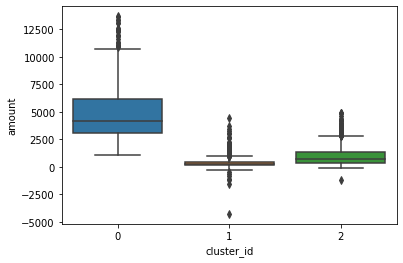

In [40]:
# plot
sns.boxplot(x ='cluster_id', y ='amount', data=grouped_df)

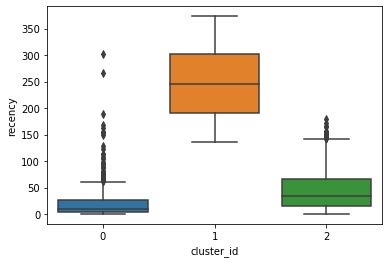

In [41]:
sns.boxplot(x='cluster_id', y='recency', data=grouped_df)

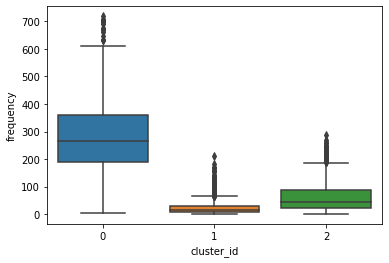

In [42]:
sns.boxplot(x='cluster_id', y='frequency', data=grouped_df)